In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
#from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import sklearn
from sklearn import metrics
import math

2023-05-06 07:47:35.094498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model 1

In [194]:
start = dt.datetime(2009, 1, 1)
end = dt.datetime(2021, 1, 1)

data = pdr.get_data_yahoo('^DJI', start, end)
data = data.reset_index()
data = data.dropna()
#data1 = data.copy()

[*********************100%***********************]  1 of 1 completed


In [195]:
train_data = data[data['Date']<"2018-01-01"]
test_data = data[data['Date']>="2018-01-01"]

## Differenced data for Model 1

In [196]:
data1 = data.copy()
data1['Close'][1:] = np.diff(data1['Close'])

/Users/danamalas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [197]:
train_data1 = data1[data1['Date']<="2018-01-01"]
test_data1 = data1[data1['Date']>"2018-01-01"]

In [199]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(train_data1['Close'].values.reshape(-1,1))

In [203]:
window_size = 50

x_train=[]
y_train=[]

for x in range(window_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_size:x, 0])
    y_train.append(scaled_data[x, 0])

In [204]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [205]:
%%capture
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=32)

In [206]:
actual_prices=test_data1['Close'].values

total_dataset=pd.concat((train_data1['Close'], test_data1['Close']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-window_size:].values
model_inputs = model_inputs.reshape(-1, 1)

In [207]:
x_test=[]

for x in range(window_size, len(model_inputs)):
    x_test.append(model_inputs[x-window_size:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)

24/24 [==============================] - 2s 22ms/step


In [208]:
predicted_prices1 = predicted_prices.copy()
predicted_prices = predicted_prices[5:]

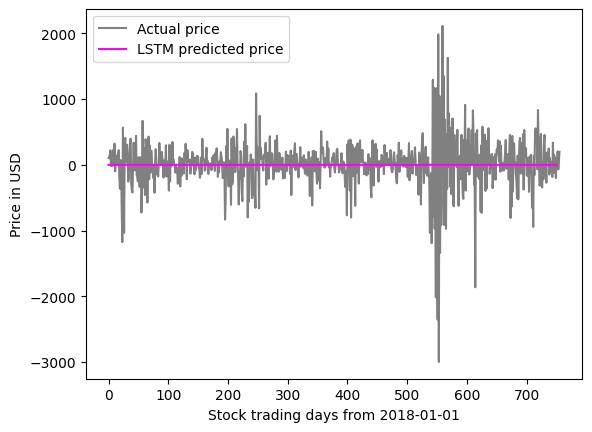

In [209]:
#Plot test predction
plt.plot(test_data1.reset_index()['Close'], color = 'grey', label = 'Actual price')
plt.plot(predicted_prices, color = 'magenta', label = 'LSTM predicted price')

plt.xlabel('Stock trading days from 2018-01-01')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

In [225]:
math.sqrt(metrics.mean_squared_error(test_data['Close'][5:],predicted_prices))

26181.23706309492

In [226]:
metrics.mean_absolute_error(test_data['Close'][5:],predicted_prices)

26117.235083988144

In [ ]:
########################################################################

# Data analysis

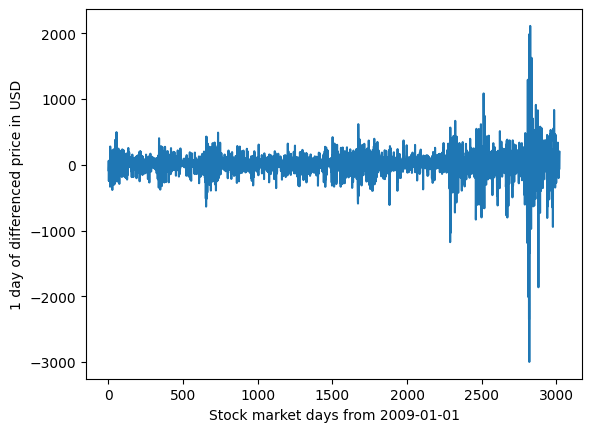

In [227]:
plt.plot(data['Close'].diff(periods=1).dropna())
plt.xlabel('Stock market days from 2009-01-01')
plt.ylabel('1 day of differenced price in USD')
plt.show()

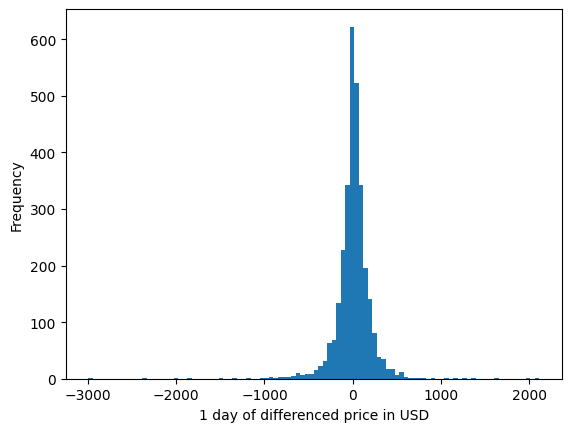

In [229]:
plt.hist(data['Close'].diff(periods=1).dropna(),bins = 100)
plt.xlabel('1 day of differenced price in USD')
plt.ylabel('Frequency')
plt.show()

In [230]:
adfuller(data['Close'].dropna().diff(periods=1).dropna()) 

(-11.336769226111153,
 1.0788949870548927e-20,
 26,
 2993,
 {'1%': -3.432536741492438,
  '5%': -2.862506160743024,
  '10%': -2.5672843129045173},
 40337.32991933587)

In [ ]:
#perform augmented Dickey-Fuller test
adfuller(data)

(-0.9753836234744063,
 0.7621363564361013,
 0,
 12,
 {'1%': -4.137829282407408,
  '5%': -3.1549724074074077,
  '10%': -2.7144769444444443},
 31.2466098872313)
Here’s how to interpret the most important values in the output:

Test statistic: -0.97538
P-value: 0.7621
Since the p-value is not less than .05, we fail to reject the null hypothesis.

This means the time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.


## För att få bort non-stationarity kan vi differentiera
#df["series"].diff(periods=1)

